In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive model

C:\Users\tamim\anaconda3\envs\DeepCrack\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available = lambda : False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
from random import *
from tqdm.notebook import tqdm, trange
from time import sleep
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from warnings import filterwarnings
filterwarnings('ignore')

In [4]:
outputs = Path('./outputs')
if not outputs.is_dir():
    outputs.mkdir()

In [5]:
# function for saving weights of trained model
def save_model(epochs, model, optimizer, criterion, name='model', descr=''):

    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                'descr': descr,
                }, f'outputs/{name}.pth')

In [6]:
# Data Preprocessing

In [7]:
# Define relevant variables for the ML task
batch_size = 64
num_classes = 7
learning_rate = 0.001
num_epochs = 2

In [8]:
train_trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomRotation(degrees=(30, 70)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

valid_trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [9]:
from torchvision.datasets import ImageFolder
train_folder = ImageFolder("D:\\FALL 2022\\MS_Thesis\\MASTER'S THESIS\\EdmCrack600\\Data_Structure(Annotated)", transform=train_trans , )
test_folder = ImageFolder("D:\\FALL 2022\\MS_Thesis\\MASTER'S THESIS\\EdmCrack600\\Data_Structure(Annotated)", transform=valid_trans , )

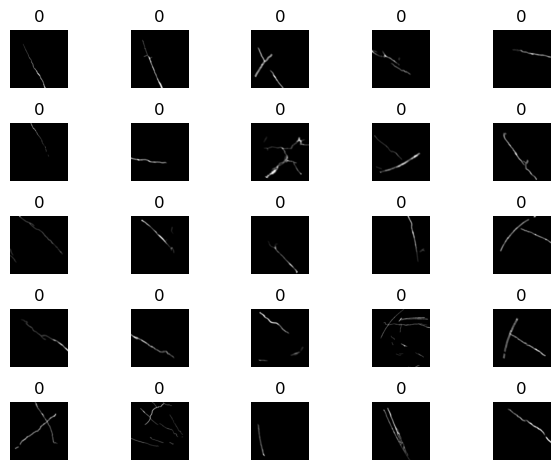

In [10]:
# Printing 25 random images from the training dataset
random_samples = np.random.randint(
    1, len(train_folder), (25))
  
for idx in range(random_samples.shape[0]):
    plt.subplot(5, 5, idx + 1)
    plt.imshow(train_folder[idx][0][0].numpy(), cmap='gray')
    plt.title(train_folder[idx][1])
    plt.axis('off')
  
plt.tight_layout()
plt.show()

In [11]:
len(train_folder.classes)

7

In [12]:
classes_name = train_folder.classes
classes_name

['ALLIGATOR ( Fatigue plus Longitudinal Cracks on Wheel Paths',
 'BLEEDING_',
 'DELAMINATION',
 'LONGITUDINAL LANE JOINT CRACKING_',
 'LONGITUDINAL OUTSIDE OF THE WHEEL PATHS_',
 'Raveling',
 'Transverse Crack']

In [13]:
# Splitting data on batches
train_loader = torch.utils.data.DataLoader(train_folder, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_folder, shuffle=False, batch_size=batch_size)

In [14]:
# Let's take a look at the first batch
data, labels = next(iter(train_loader))
# data, labels = data.cpu(), labels.cpu() ## Solution: https://stackoverflow.com/questions/59013109/runtimeerror-input-type-torch-floattensor-and-weight-type-torch-cuda-floatte

In [15]:
data.size

<function Tensor.size>

In [16]:
data.shape

torch.Size([64, 3, 224, 224])

In [17]:
type(data)

torch.Tensor

# Load the model

In [18]:
import torch
model = models.vgg19(pretrained=True).to(device)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [1]:
model.classifier[6] = nn.Linear(4096, 7).to(device) # original model has outputs for 1000 classes. 
# But there are only 75 classes so we have to change output layer

NameError: name 'nn' is not defined

In [ ]:
# Freezing all layers except last 15
for param in list(model.parameters())[:-15]:
    param.requires_grad = False

In [ ]:
## Defining model optimizer and loss function
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
from torchsummary import summary
summary(model, (3, 224, 224))

In [ ]:
def mean(l: list):
    return sum(l) / len(l)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
def plot_losses_and_acc(train_losses, train_accuracies, valid_losses, valid_accuracies): 
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    axes[0].plot(train_losses, label='train_losses')
    axes[0].plot(valid_losses, label='valid_losses')
    axes[0].set_title('Losses')
    axes[0].legend()
    
    axes[1].plot(train_accuracies, label='train_losses')
    axes[1].plot(valid_accuracies, label='valid_losses')
    axes[1].set_title('Accuracy')
    axes[1].legend()

In [ ]:
def validate(model, valid_data, loss_fn):
    valid_losses, valid_accuracies = [], []
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in tqdm(valid_data, leave=False):
            X_batch, y_batch = X_batch.to(device).float(), y_batch.to(device).long()
            logits = model(X_batch)
            loss = loss_fn(logits, y_batch)
            valid_losses.append(loss.item())
            preds = torch.argmax(logits, axis=1)
            
            valid_accuracies.append(((preds == y_batch).sum() / len(preds)).item())
    return mean(valid_losses), mean(valid_accuracies)
    

def train(model, train_data, valid_data, loss_fn, opt, epoches=5):
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []
    
    for epoch in tqdm(range(epoches)):
        train_loss = []
        train_acc = []
        model.train()
        for X_batch, y_batch in tqdm(train_data, leave=False):
            opt.zero_grad()

            X_batch, y_batch = X_batch.to(device).float(), y_batch.to(device).long()
            logits = model(X_batch)
            loss = loss_fn(logits, y_batch,)
            train_loss.append(loss.item())

            pred = torch.argmax(logits, dim=1)
            train_acc.append(((pred == y_batch).sum() / len(pred)).item())
            loss.backward()
            opt.step()

        valid_loss, valid_accuracy = validate(model, valid_data, loss_fn)

        train_accuracies.append(mean(train_acc))
        train_losses.append(mean(train_loss))
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)
        
        print(f'epoch: {epoch}: train_loss: {mean(train_losses)}, train_acc: {mean(train_acc)}, val_loss: {valid_loss}, val_acc: {valid_accuracy}')
    plot_losses_and_acc(train_losses, train_accuracies, valid_losses, valid_accuracies)
    return model, train_losses, train_accuracies, valid_losses, valid_accuracies

In [ ]:
from tqdm import tqdm

In [ ]:
model, train_losses, train_accuracies, valid_losses, valid_accuracies = train(model, train_loader, test_loader, loss_fn, opt, epoches=2)

In [ ]:
save_model(25, model, opt, loss_fn, 'vgg19', descr='15 unfrozen layers; 1e-4 lr')

In [ ]:
valid_loss, valid_acc = validate(model, test_loader, loss_fn)

In [ ]:
print(valid_loss, valid_acc)